In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

print("alpha",alpha)
print(datetime.datetime.now())

alpha 0.1
2023-06-03 11:58:46.390006


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 48
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-10.7155)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(1.8864)
penalty_target_min tensor(-12.2278) penalty_target_max tensor(17.1780)
train_loss:  -10.227649570465086
valid_loss:  -9.392062255859376
h_min_tilde -12.227775 ell_tilde -10.060532107543946 kappa_tilde 0.0006792759591977168


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.6689300537109375e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 6.279654026031494

 2 7.212800025939941

 3 7.47543478012085

 4 7.056241273880005

 5 7.213810682296753

 6 7.097951650619507

 7 7.210397481918335

 8 7.204688310623169

 9 7.083942413330078

 10 7.246517658233643

 11 7.073766708374023

 12 6.942616701126099

 13 7.08903169631958

 14 7.117828607559204

 15 7.192164659500122

 16 7.15900182723999

 17 7.150583028793335

 18 7.014362335205078

 19 7.16200590133667

 20 7.0696868896484375

 21 7.1672868728637695

 22 7.1647162437438965

 23 7.310752630233765

 24 7.017376184463501

 25 7.159687519073486

 26 7.1499059200286865

 27 7.068443298339844

 28 7.135973930358887

 29 7.246429681777954

 30 7.096624851226807

 31 7.115805625915527

 32 7.275925159454346

 33 7.122705936431885

 34 6.950921535491943

 35 7.096330404281616

 36 7.139937877655029

 37 7.061496019363403

 38 6.95297908782959

 39 6.966367721557617

 40 7.083518028259277

 41 6.931421756744385

 42 7.172478199005127

 43 7.341398477554321

 44 7.02568244934082

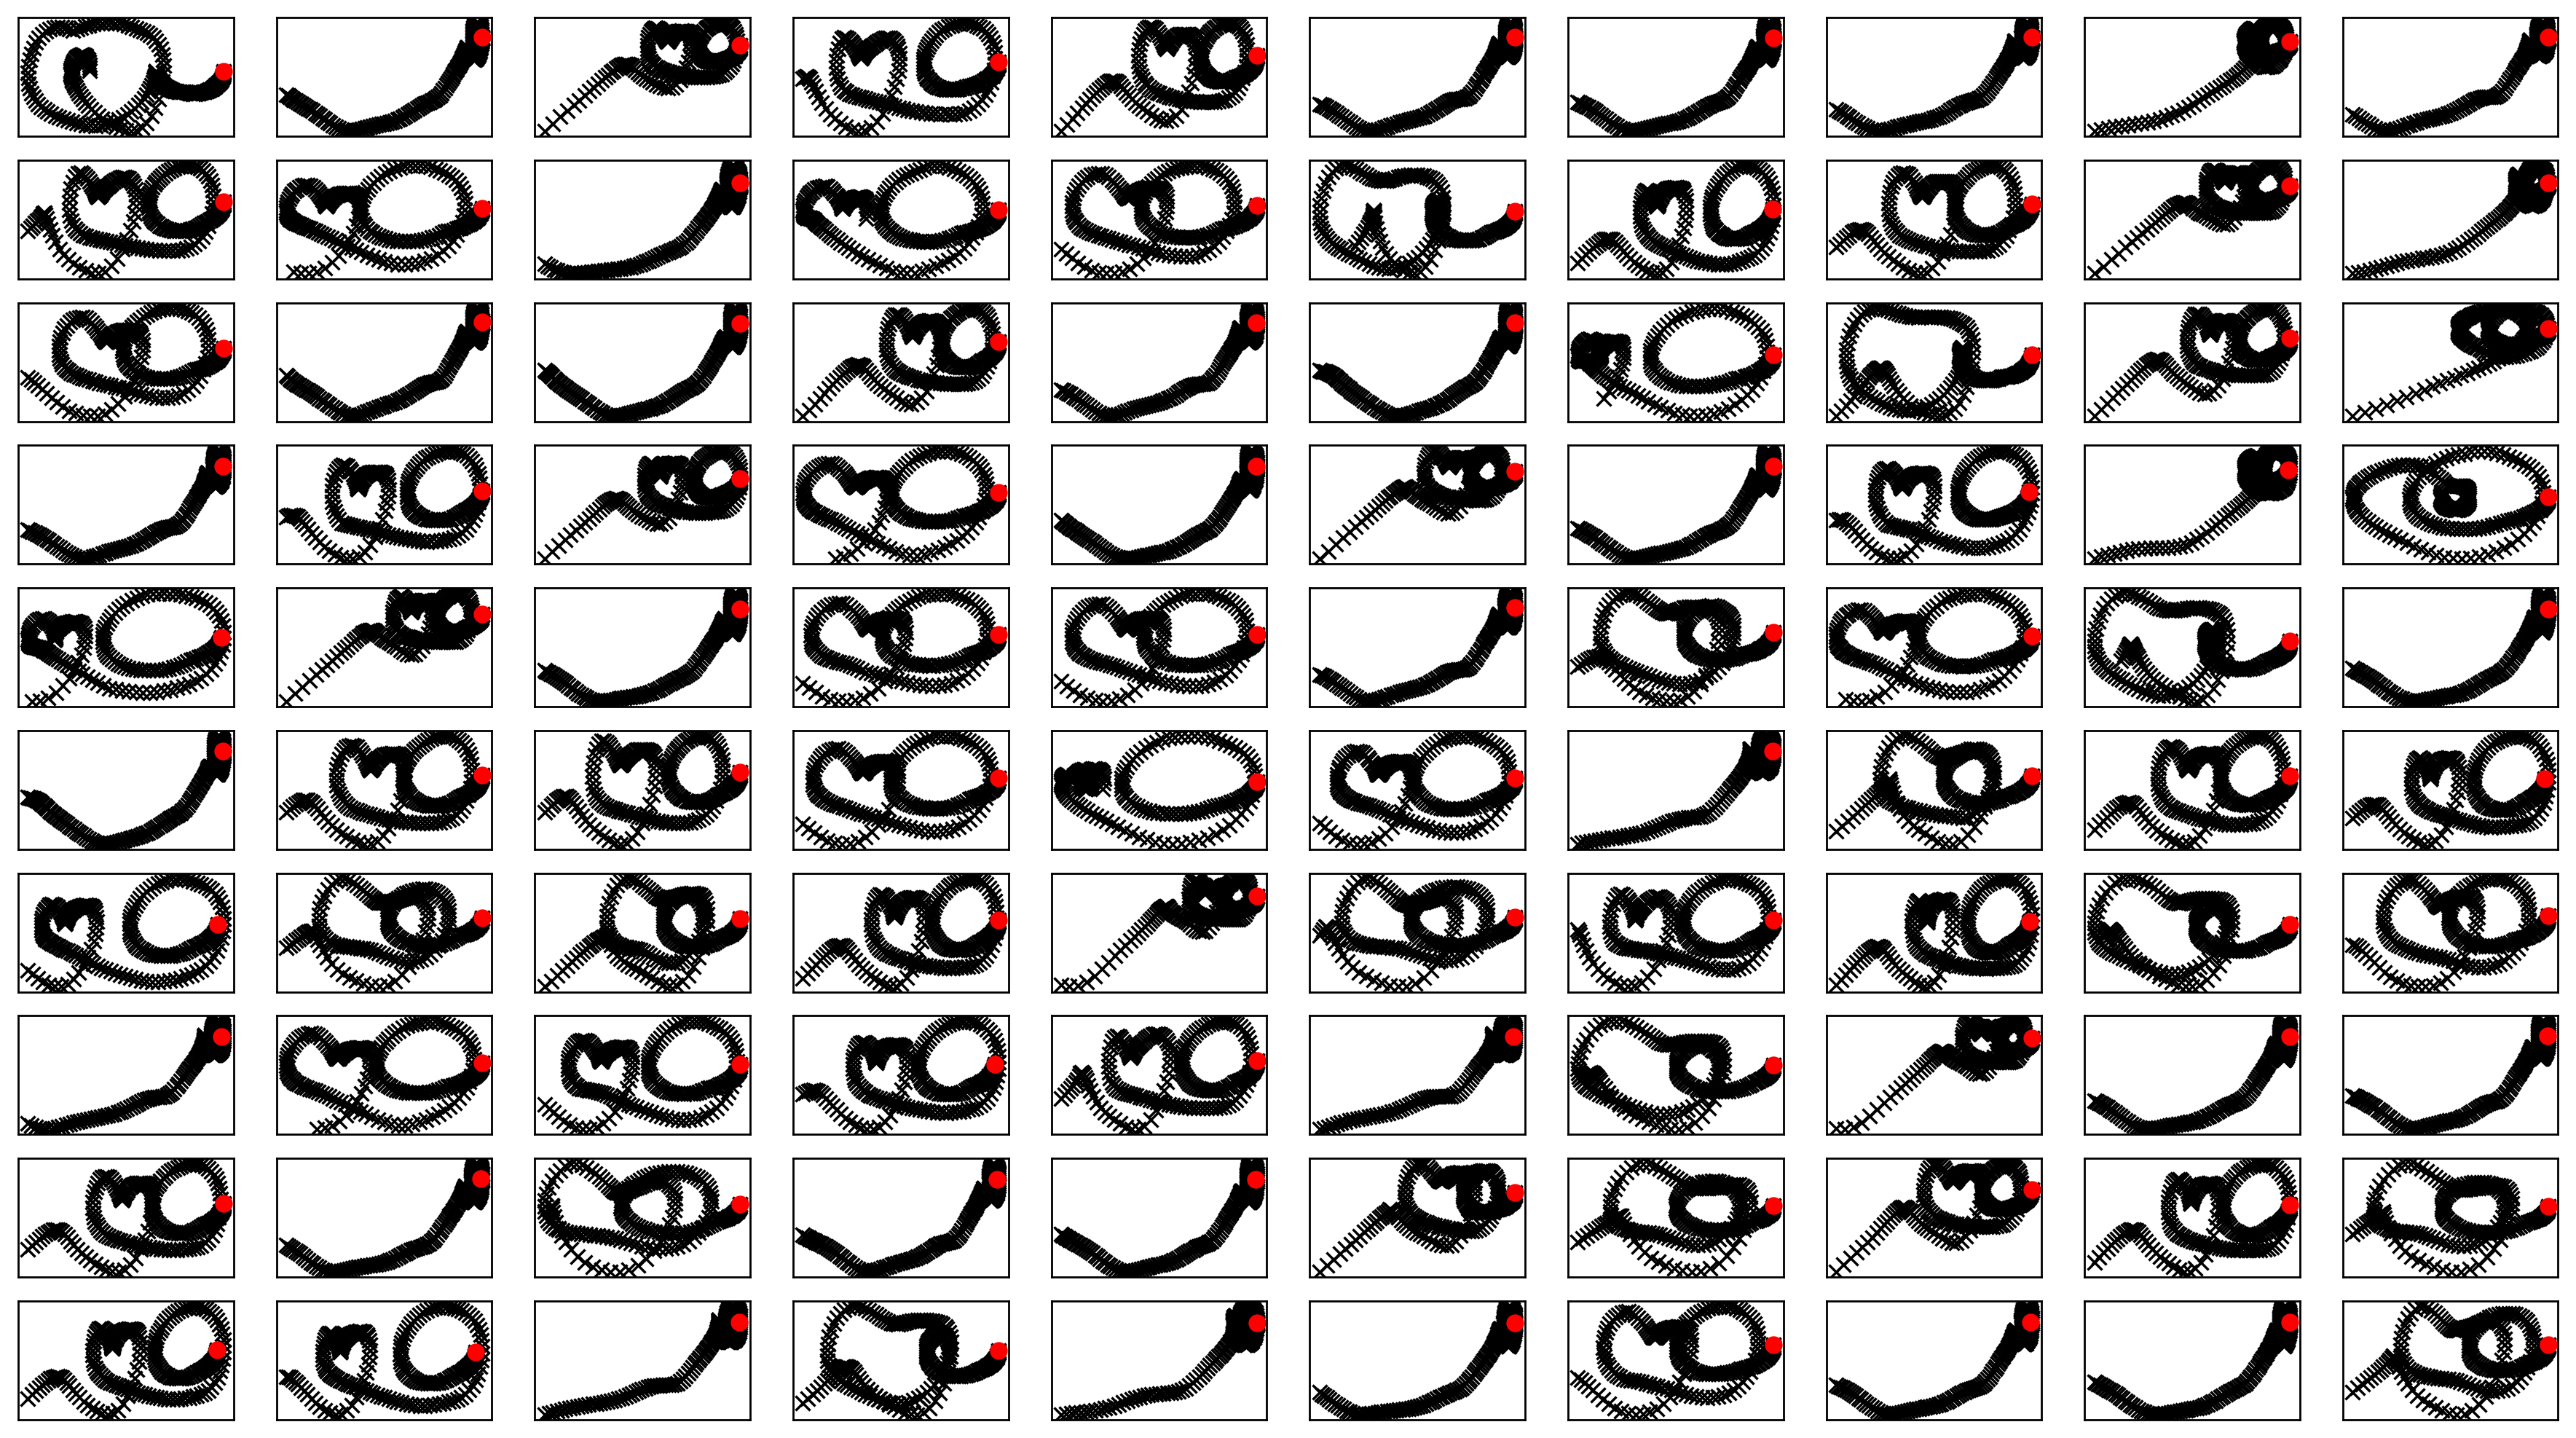

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

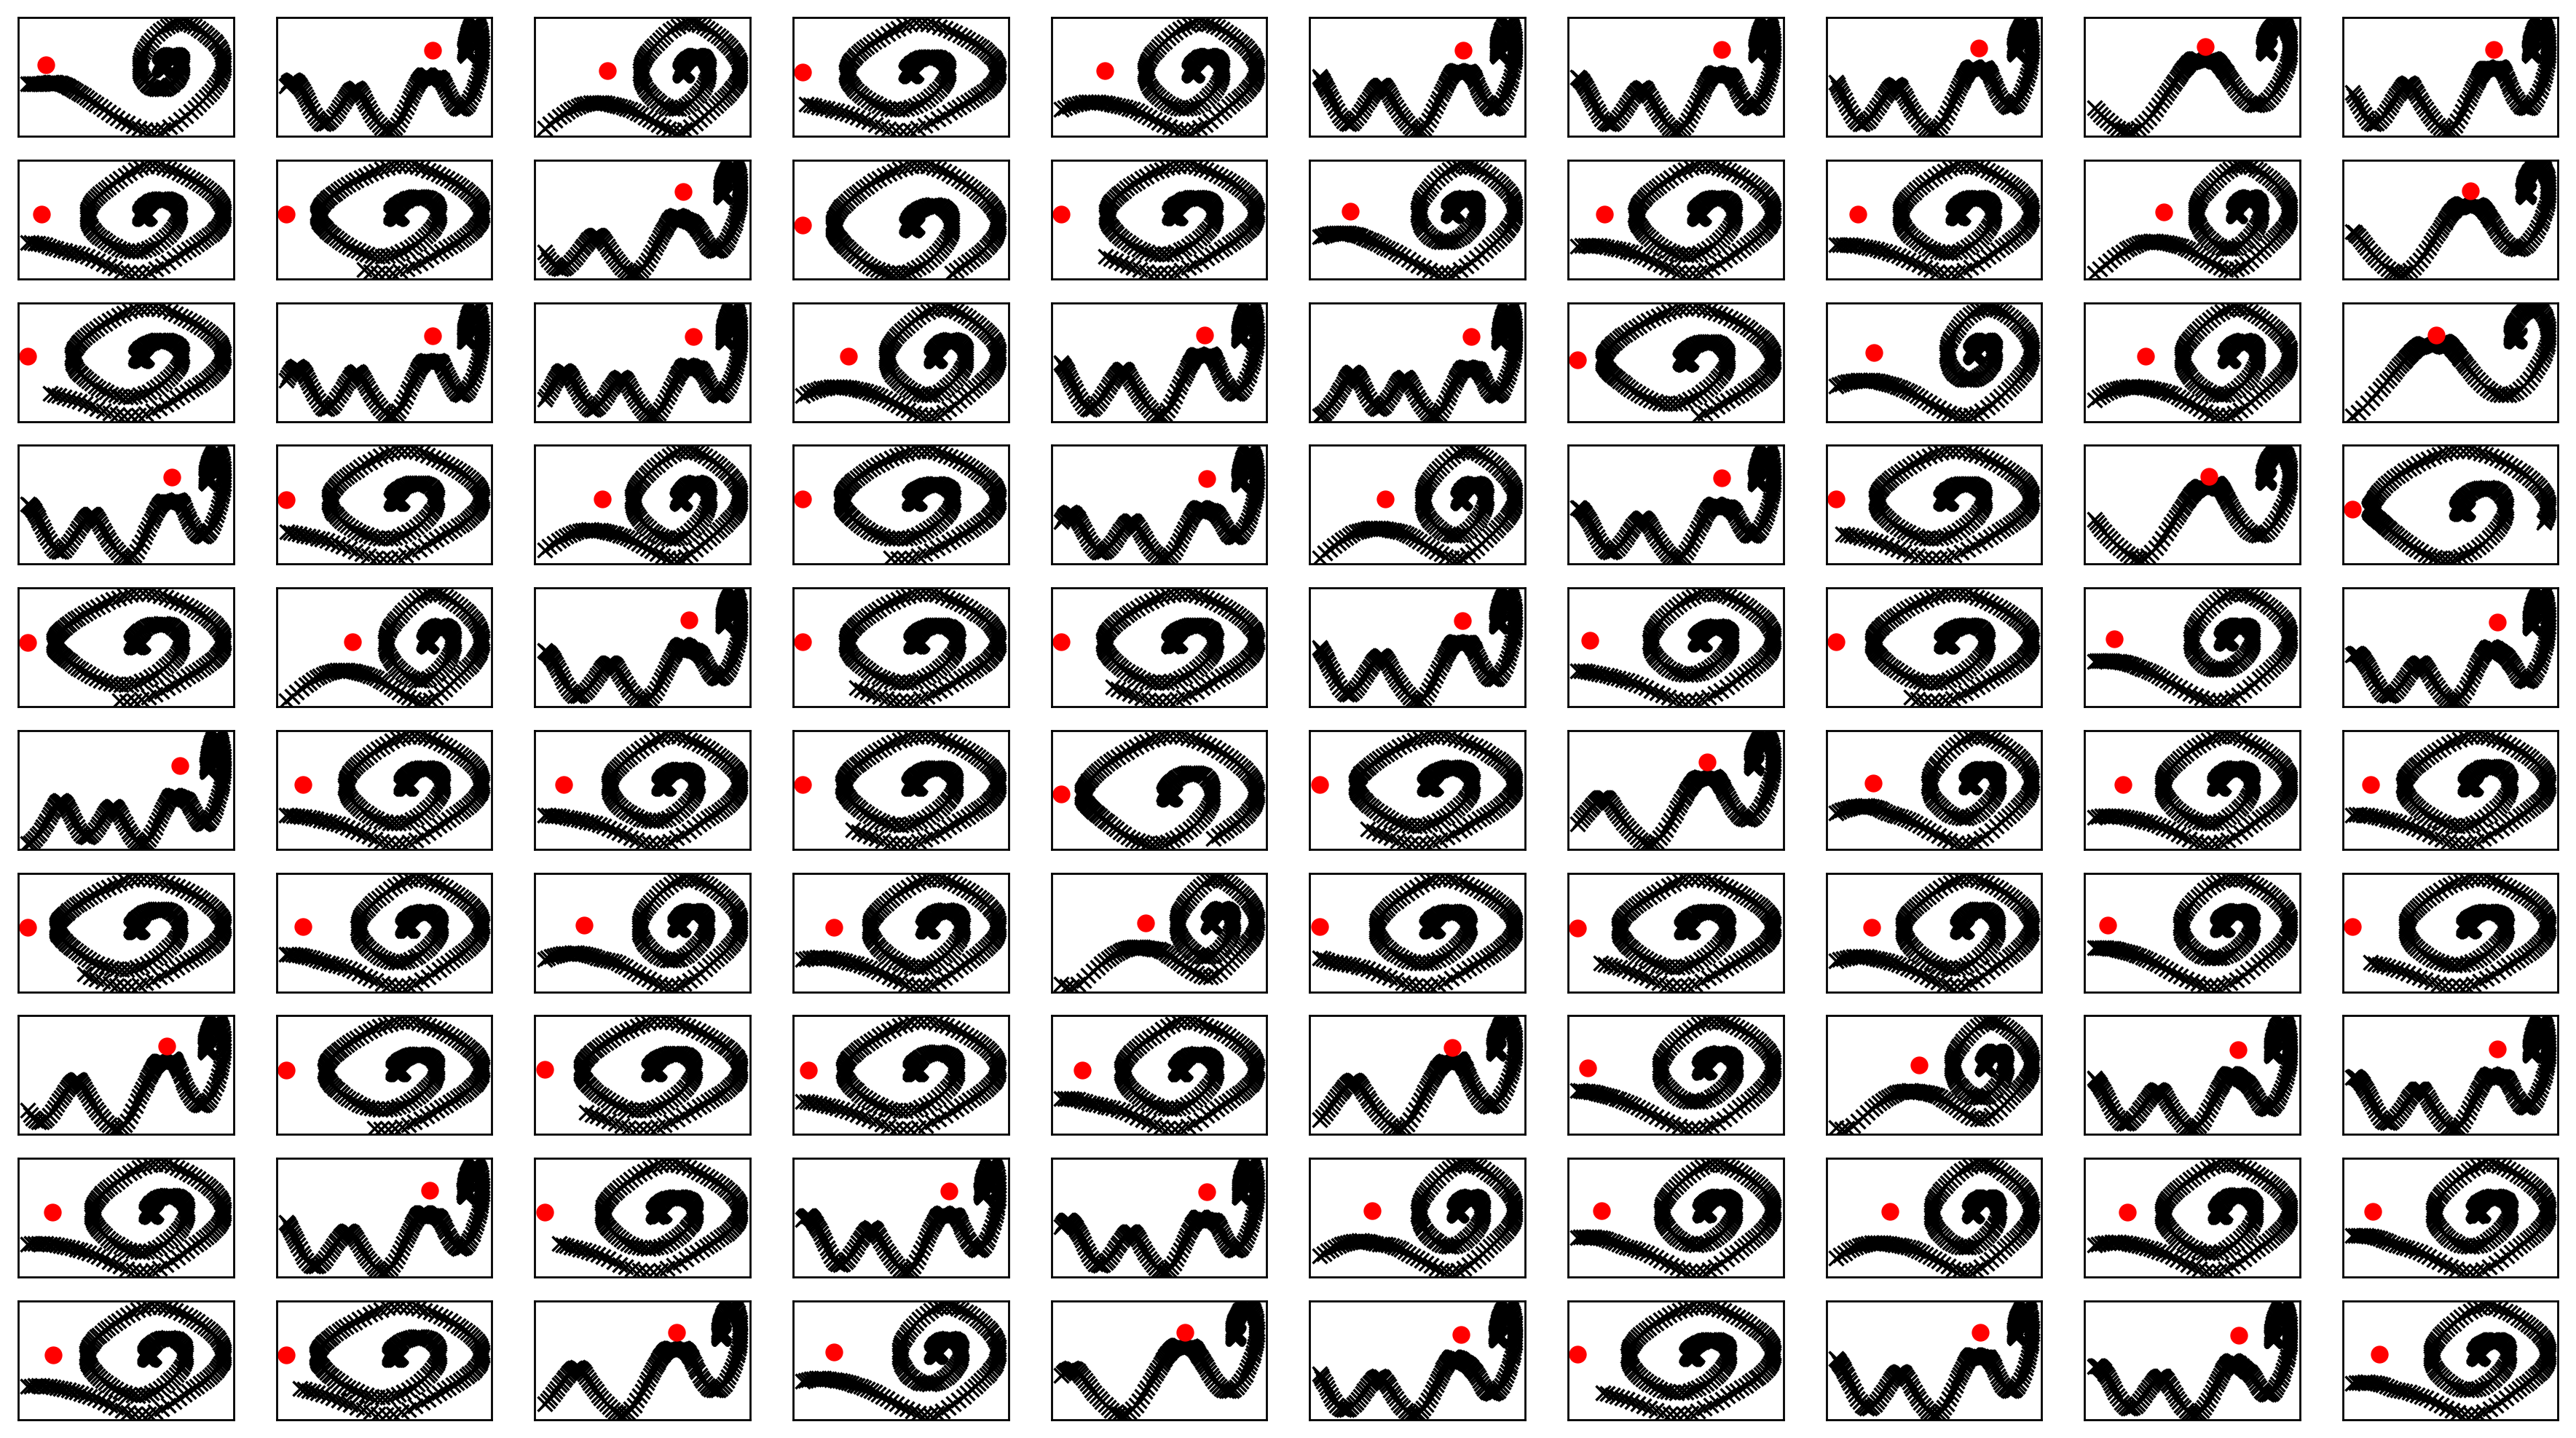

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-06-03 12:10:42.552669


# Iter 1

In [9]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [10]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.39772  validloss 1.45124±0.00000  bestvalidloss 1.45124  last_update 0
train: iter 1  trainloss 1.37449  validloss 1.37243±0.00000  bestvalidloss 1.37243  last_update 0
train: iter 2  trainloss 1.36015  validloss 1.36457±0.00000  bestvalidloss 1.36457  last_update 0
train: iter 3  trainloss 1.33443  validloss 1.35464±0.00000  bestvalidloss 1.35464  last_update 0
train: iter 4  trainloss 1.29301  validloss 1.33351±0.00000  bestvalidloss 1.33351  last_update 0
train: iter 5  trainloss 1.24501  validloss 1.28837±0.00000  bestvalidloss 1.28837  last_update 0
train: iter 6  trainloss 1.18016  validloss 1.21860±0.00000  bestvalidloss 1.21860  last_update 0
train: iter 7  trainloss 1.12631  validloss 1.15572±0.00000  bestvalidloss 1.15572  last_update 0
train: iter 8  trainloss 1.08090  validloss 1.11612±0.00000  bestvalidloss 1.11612  last_update 0
train: iter 9  trainloss 1.05005  validloss 1.03752±0.00000  bestvalidloss 1.03752  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.75136  validloss 0.71480±0.00000  bestvalidloss 0.68969  last_update 13
train: iter 84  trainloss 0.74420  validloss 0.72114±0.00000  bestvalidloss 0.68969  last_update 14
train: iter 85  trainloss 0.74746  validloss 0.70468±0.00000  bestvalidloss 0.68969  last_update 15
train: iter 86  trainloss 0.73966  validloss 0.70300±0.00000  bestvalidloss 0.68969  last_update 16
train: iter 87  trainloss 0.75167  validloss 0.73076±0.00000  bestvalidloss 0.68969  last_update 17
train: iter 88  trainloss 0.81021  validloss 0.77925±0.00000  bestvalidloss 0.68969  last_update 18
train: iter 89  trainloss 0.75080  validloss 0.69578±0.00000  bestvalidloss 0.68969  last_update 19
train: iter 90  trainloss 0.73964  validloss 0.69917±0.00000  bestvalidloss 0.68969  last_update 20
train: iter 91  trainloss 0.74586  validloss 0.70370±0.00000  bestvalidloss 0.68969  last_update 21
train: iter 92  trainloss 0.74044  validloss 0.69415±0.00000  bestvalidloss 0.68969  last_update 22


train: iter 165  trainloss 0.69405  validloss 0.69542±0.00000  bestvalidloss 0.67745  last_update 33
train: iter 166  trainloss 0.68426  validloss 0.68458±0.00000  bestvalidloss 0.67745  last_update 34
train: iter 167  trainloss 0.70047  validloss 0.72055±0.00000  bestvalidloss 0.67745  last_update 35
train: iter 168  trainloss 0.69282  validloss 0.70978±0.00000  bestvalidloss 0.67745  last_update 36
train: iter 169  trainloss 0.69175  validloss 0.68175±0.00000  bestvalidloss 0.67745  last_update 37
train: iter 170  trainloss 0.69744  validloss 0.68020±0.00000  bestvalidloss 0.67745  last_update 38
train: iter 171  trainloss 0.69938  validloss 0.71881±0.00000  bestvalidloss 0.67745  last_update 39
train: iter 172  trainloss 0.69533  validloss 0.69503±0.00000  bestvalidloss 0.67745  last_update 40
train: iter 173  trainloss 0.69168  validloss 0.69167±0.00000  bestvalidloss 0.67745  last_update 41
train: iter 174  trainloss 0.68793  validloss 0.71612±0.00000  bestvalidloss 0.67745  last_

train: iter 247  trainloss 0.67778  validloss 0.67757±0.00000  bestvalidloss 0.66239  last_update 6
train: iter 248  trainloss 0.67888  validloss 0.67409±0.00000  bestvalidloss 0.66239  last_update 7
train: iter 249  trainloss 0.66874  validloss 0.66877±0.00000  bestvalidloss 0.66239  last_update 8
train: iter 250  trainloss 0.65656  validloss 0.67854±0.00000  bestvalidloss 0.66239  last_update 9
train: iter 251  trainloss 0.65441  validloss 0.69255±0.00000  bestvalidloss 0.66239  last_update 10
train: iter 252  trainloss 0.67334  validloss 0.67488±0.00000  bestvalidloss 0.66239  last_update 11
train: iter 253  trainloss 0.65227  validloss 0.68593±0.00000  bestvalidloss 0.66239  last_update 12
train: iter 254  trainloss 0.66430  validloss 0.70018±0.00000  bestvalidloss 0.66239  last_update 13
train: iter 255  trainloss 0.65179  validloss 0.67709±0.00000  bestvalidloss 0.66239  last_update 14
train: iter 256  trainloss 0.66054  validloss 0.67613±0.00000  bestvalidloss 0.66239  last_upda

train: iter 329  trainloss 0.60261  validloss 0.61923±0.00000  bestvalidloss 0.61600  last_update 16
train: iter 330  trainloss 0.60476  validloss 0.69637±0.00000  bestvalidloss 0.61600  last_update 17
train: iter 331  trainloss 0.60478  validloss 0.65728±0.00000  bestvalidloss 0.61600  last_update 18
train: iter 332  trainloss 0.61550  validloss 0.66511±0.00000  bestvalidloss 0.61600  last_update 19
train: iter 333  trainloss 0.62851  validloss 0.62895±0.00000  bestvalidloss 0.61600  last_update 20
train: iter 334  trainloss 0.60634  validloss 0.63186±0.00000  bestvalidloss 0.61600  last_update 21
train: iter 335  trainloss 0.61437  validloss 0.63117±0.00000  bestvalidloss 0.61600  last_update 22
train: iter 336  trainloss 0.62520  validloss 0.62308±0.00000  bestvalidloss 0.61600  last_update 23
train: iter 337  trainloss 0.62016  validloss 0.64300±0.00000  bestvalidloss 0.61600  last_update 24
train: iter 338  trainloss 0.60213  validloss 0.62863±0.00000  bestvalidloss 0.61600  last_

train: iter 411  trainloss 0.57965  validloss 0.59727±0.00000  bestvalidloss 0.59727  last_update 0
train: iter 412  trainloss 0.59679  validloss 0.61349±0.00000  bestvalidloss 0.59727  last_update 1
train: iter 413  trainloss 0.58009  validloss 0.62084±0.00000  bestvalidloss 0.59727  last_update 2
train: iter 414  trainloss 0.57936  validloss 0.61284±0.00000  bestvalidloss 0.59727  last_update 3
train: iter 415  trainloss 0.58467  validloss 0.61870±0.00000  bestvalidloss 0.59727  last_update 4
train: iter 416  trainloss 0.59583  validloss 0.59751±0.00000  bestvalidloss 0.59727  last_update 5
train: iter 417  trainloss 0.58463  validloss 0.60334±0.00000  bestvalidloss 0.59727  last_update 6
train: iter 418  trainloss 0.57544  validloss 0.60786±0.00000  bestvalidloss 0.59727  last_update 7
train: iter 419  trainloss 0.58950  validloss 0.61770±0.00000  bestvalidloss 0.59727  last_update 8
train: iter 420  trainloss 0.57875  validloss 0.63146±0.00000  bestvalidloss 0.59727  last_update 9


train: iter 493  trainloss 0.57810  validloss 0.60684±0.00000  bestvalidloss 0.58323  last_update 30
train: iter 494  trainloss 0.55845  validloss 0.61903±0.00000  bestvalidloss 0.58323  last_update 31
train: iter 495  trainloss 0.57492  validloss 0.58760±0.00000  bestvalidloss 0.58323  last_update 32
train: iter 496  trainloss 0.56252  validloss 0.60130±0.00000  bestvalidloss 0.58323  last_update 33
train: iter 497  trainloss 0.57950  validloss 0.60190±0.00000  bestvalidloss 0.58323  last_update 34
train: iter 498  trainloss 0.57199  validloss 0.59733±0.00000  bestvalidloss 0.58323  last_update 35
train: iter 499  trainloss 0.56881  validloss 0.61861±0.00000  bestvalidloss 0.58323  last_update 36
train: iter 500  trainloss 0.58016  validloss 0.59132±0.00000  bestvalidloss 0.58323  last_update 37
train: iter 501  trainloss 0.55629  validloss 0.59870±0.00000  bestvalidloss 0.58323  last_update 38
train: iter 502  trainloss 0.57695  validloss 0.59850±0.00000  bestvalidloss 0.58323  last_

([1.3977218210697173,
  1.3744914323091506,
  1.3601488128304482,
  1.3344345912337303,
  1.293013271689415,
  1.2450082272291183,
  1.1801609985530377,
  1.1263136833906173,
  1.0808956824243068,
  1.0500549979507923,
  1.0227774754166603,
  1.0013001583516599,
  0.9926023058593273,
  0.9657925724983215,
  0.9594167377799749,
  0.9433753214776516,
  0.932959183305502,
  0.9252585683017969,
  0.9068375084549188,
  0.9016246657818556,
  0.8887187570333481,
  0.8895450752228499,
  0.877785824239254,
  0.8643435958772898,
  0.8717666830867529,
  0.848357730358839,
  0.8571499563753605,
  0.8562870845198631,
  0.8454655587673188,
  0.8360007785260677,
  0.8312158163636922,
  0.8282691381871701,
  0.8377918161451816,
  0.8337769452482462,
  0.8248999178409576,
  0.8169420946389436,
  0.8175240885466337,
  0.8467864129692316,
  0.8282978128641844,
  0.8116142369806767,
  0.8215790688991547,
  0.8024787615984679,
  0.8152132548391819,
  0.8153797626495362,
  0.8043311081826687,
  0.8138018637

In [11]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.206545551225544
valid_loss:  -3.530879438018799
weight_alpha 1.0 h_min_tilde -12.227775 ell_tilde -4.071412328584195 kappa_tilde 0.0003501480772959548
train_loss:  -6.395016642189026
valid_loss:  -5.267615276622772
weight_alpha 0.1 h_min_tilde -12.227775 ell_tilde -6.169536369075775 kappa_tilde 0.0004062812927173764


In [12]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1309.12988  validloss -1054.20826±0.00000  bestvalidloss -1054.20826  last_update 0
train: iter 1  trainloss -1264.79738  validloss -981.74819±0.00000  bestvalidloss -1054.20826  last_update 1
train: iter 2  trainloss -1271.22976  validloss -1059.70809±0.00000  bestvalidloss -1059.70809  last_update 0
train: iter 3  trainloss -1277.86994  validloss -964.12042±0.00000  bestvalidloss -1059.70809  last_update 1
train: iter 4  trainloss -1278.72371  validloss -1031.94717±0.00000  bestvalidloss -1059.70809  last_update 2
train: iter 5  trainloss -1282.80127  validloss -1007.49590±0.00000  bestvalidloss -1059.70809  last_update 3
train: iter 6  trainloss -1279.42508  validloss -955.42024±0.00000  bestvalidloss -1059.70809  last_update 4
train: iter 7  trainloss -1290.05693  validloss -1047.66824±0.00000  bestvalidloss -1059.70809  last_update 5
train: iter 8  trainloss -1267.88327  validloss -914.58966±0.00000  bestvalidl

train: iter 74  trainloss -1338.55140  validloss -1012.44701±0.00000  bestvalidloss -1151.15155  last_update 28
train: iter 75  trainloss -1380.76674  validloss -1088.97871±0.00000  bestvalidloss -1151.15155  last_update 29
train: iter 76  trainloss -1337.17419  validloss -901.13029±0.00000  bestvalidloss -1151.15155  last_update 30
train: iter 77  trainloss -1356.17903  validloss -1039.96363±0.00000  bestvalidloss -1151.15155  last_update 31
train: iter 78  trainloss -1356.89525  validloss -1002.63280±0.00000  bestvalidloss -1151.15155  last_update 32
train: iter 79  trainloss -1350.04043  validloss -1116.63672±0.00000  bestvalidloss -1151.15155  last_update 33
train: iter 80  trainloss -1330.80384  validloss -1054.02029±0.00000  bestvalidloss -1151.15155  last_update 34
train: iter 81  trainloss -1332.92725  validloss -871.22126±0.00000  bestvalidloss -1151.15155  last_update 35
train: iter 82  trainloss -1345.94177  validloss -1046.26983±0.00000  bestvalidloss -1151.15155  last_upda

train: iter 147  trainloss -1415.50089  validloss -1073.26606±0.00000  bestvalidloss -1153.40717  last_update 4
train: iter 148  trainloss -1443.31629  validloss -1134.98834±0.00000  bestvalidloss -1153.40717  last_update 5
train: iter 149  trainloss -1425.41486  validloss -1052.52012±0.00000  bestvalidloss -1153.40717  last_update 6
train: iter 150  trainloss -1449.70497  validloss -1093.09701±0.00000  bestvalidloss -1153.40717  last_update 7
train: iter 151  trainloss -1455.94152  validloss -958.86438±0.00000  bestvalidloss -1153.40717  last_update 8
train: iter 152  trainloss -1453.64140  validloss -1177.49836±0.00000  bestvalidloss -1177.49836  last_update 0
train: iter 153  trainloss -1456.14894  validloss -1138.74405±0.00000  bestvalidloss -1177.49836  last_update 1
train: iter 154  trainloss -1436.69235  validloss -1096.42042±0.00000  bestvalidloss -1177.49836  last_update 2
train: iter 155  trainloss -1435.53110  validloss -1161.77609±0.00000  bestvalidloss -1177.49836  last_up

train: iter 220  trainloss -1507.52416  validloss -1137.50909±0.00000  bestvalidloss -1239.42487  last_update 1
train: iter 221  trainloss -1534.19534  validloss -1232.52039±0.00000  bestvalidloss -1239.42487  last_update 2
train: iter 222  trainloss -1536.47351  validloss -1143.05606±0.00000  bestvalidloss -1239.42487  last_update 3
train: iter 223  trainloss -1541.36966  validloss -1232.92433±0.00000  bestvalidloss -1239.42487  last_update 4
train: iter 224  trainloss -1523.03908  validloss -1052.65006±0.00000  bestvalidloss -1239.42487  last_update 5
train: iter 225  trainloss -1520.49845  validloss -1243.36771±0.00000  bestvalidloss -1243.36771  last_update 0
train: iter 226  trainloss -1515.10009  validloss -1138.64910±0.00000  bestvalidloss -1243.36771  last_update 1
train: iter 227  trainloss -1546.75499  validloss -1150.84206±0.00000  bestvalidloss -1243.36771  last_update 2
train: iter 228  trainloss -1552.66072  validloss -971.43810±0.00000  bestvalidloss -1243.36771  last_up

train: iter 293  trainloss -1600.01533  validloss -1170.96050±0.00000  bestvalidloss -1312.83789  last_update 37
train: iter 294  trainloss -1609.76810  validloss -1262.64013±0.00000  bestvalidloss -1312.83789  last_update 38
train: iter 295  trainloss -1595.83751  validloss -1266.54354±0.00000  bestvalidloss -1312.83789  last_update 39
train: iter 296  trainloss -1597.99767  validloss -1229.11790±0.00000  bestvalidloss -1312.83789  last_update 40
train: iter 297  trainloss -1575.66092  validloss -1217.49259±0.00000  bestvalidloss -1312.83789  last_update 41
train: iter 298  trainloss -1613.42708  validloss -1226.40322±0.00000  bestvalidloss -1312.83789  last_update 42
train: iter 299  trainloss -1628.68957  validloss -1282.52850±0.00000  bestvalidloss -1312.83789  last_update 43
train: iter 300  trainloss -1590.08219  validloss -1236.77903±0.00000  bestvalidloss -1312.83789  last_update 44
train: iter 301  trainloss -1580.58380  validloss -1304.85770±0.00000  bestvalidloss -1312.83789

train: iter 366  trainloss -1643.47937  validloss -1296.26525±0.00000  bestvalidloss -1355.97379  last_update 2
train: iter 367  trainloss -1642.15910  validloss -1254.30573±0.00000  bestvalidloss -1355.97379  last_update 3
train: iter 368  trainloss -1634.53422  validloss -1299.61701±0.00000  bestvalidloss -1355.97379  last_update 4
train: iter 369  trainloss -1642.53412  validloss -1291.30605±0.00000  bestvalidloss -1355.97379  last_update 5
train: iter 370  trainloss -1656.09846  validloss -1259.40989±0.00000  bestvalidloss -1355.97379  last_update 6
train: iter 371  trainloss -1620.57627  validloss -1305.60706±0.00000  bestvalidloss -1355.97379  last_update 7
train: iter 372  trainloss -1646.50613  validloss -1238.74582±0.00000  bestvalidloss -1355.97379  last_update 8
train: iter 373  trainloss -1641.84308  validloss -1276.74870±0.00000  bestvalidloss -1355.97379  last_update 9
train: iter 374  trainloss -1654.95165  validloss -1268.69412±0.00000  bestvalidloss -1355.97379  last_u

train: iter 439  trainloss -1645.70829  validloss -1227.00058±0.00000  bestvalidloss -1355.97379  last_update 75
train: iter 440  trainloss -1653.89321  validloss -1044.32922±0.00000  bestvalidloss -1355.97379  last_update 76
train: iter 441  trainloss -1669.37873  validloss -1182.48816±0.00000  bestvalidloss -1355.97379  last_update 77
train: iter 442  trainloss -1652.99461  validloss -776.03440±0.00000  bestvalidloss -1355.97379  last_update 78
train: iter 443  trainloss -1649.93614  validloss -1300.94757±0.00000  bestvalidloss -1355.97379  last_update 79
train: iter 444  trainloss -1658.02902  validloss -1212.01018±0.00000  bestvalidloss -1355.97379  last_update 80
train: iter 445  trainloss -1644.54461  validloss -1285.78090±0.00000  bestvalidloss -1355.97379  last_update 81
train: iter 446  trainloss -1663.35853  validloss -1269.21475±0.00000  bestvalidloss -1355.97379  last_update 82
train: iter 447  trainloss -1643.75558  validloss -1282.49496±0.00000  bestvalidloss -1355.97379 

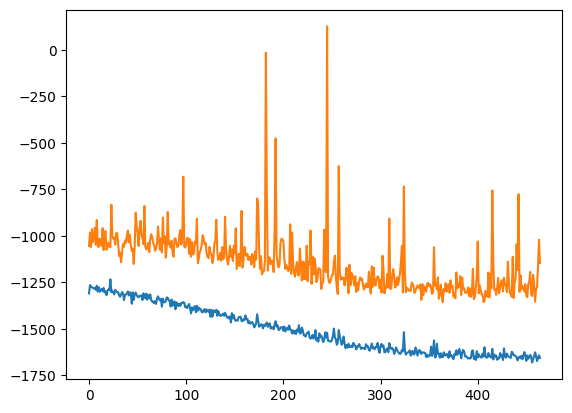

alpha 0.1 default_lr 0.0005


In [13]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [14]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [15]:
print(datetime.datetime.now())

2023-06-03 12:33:25.384332


# Iter2

In [16]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [17]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.72272  validloss 2.92217±0.00000  bestvalidloss 2.92217  last_update 0
train: iter 1  trainloss 1.23097  validloss 1.34720±0.00000  bestvalidloss 1.34720  last_update 0
train: iter 2  trainloss 1.05080  validloss 1.06191±0.00000  bestvalidloss 1.06191  last_update 0
train: iter 3  trainloss 0.96729  validloss 0.99074±0.00000  bestvalidloss 0.99074  last_update 0
train: iter 4  trainloss 0.92087  validloss 0.95872±0.00000  bestvalidloss 0.95872  last_update 0
train: iter 5  trainloss 0.89289  validloss 0.89366±0.00000  bestvalidloss 0.89366  last_update 0
train: iter 6  trainloss 0.88259  validloss 0.90765±0.00000  bestvalidloss 0.89366  last_update 1
train: iter 7  trainloss 0.85575  validloss 0.88675±0.00000  bestvalidloss 0.88675  last_update 0
train: iter 8  trainloss 0.84603  validloss 0.88148±0.00000  bestvalidloss 0.88148  last_update 0
train: iter 9  trainloss 0.83399  validloss 0.88698±0.00000  bestvalidloss 0.88148  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.69516  validloss 0.72411±0.00000  bestvalidloss 0.72411  last_update 0
train: iter 84  trainloss 0.69504  validloss 0.74758±0.00000  bestvalidloss 0.72411  last_update 1
train: iter 85  trainloss 0.69747  validloss 0.73346±0.00000  bestvalidloss 0.72411  last_update 2
train: iter 86  trainloss 0.69144  validloss 0.74716±0.00000  bestvalidloss 0.72411  last_update 3
train: iter 87  trainloss 0.70207  validloss 0.74958±0.00000  bestvalidloss 0.72411  last_update 4
train: iter 88  trainloss 0.68929  validloss 0.76956±0.00000  bestvalidloss 0.72411  last_update 5
train: iter 89  trainloss 0.69704  validloss 0.76852±0.00000  bestvalidloss 0.72411  last_update 6
train: iter 90  trainloss 0.69613  validloss 0.75217±0.00000  bestvalidloss 0.72411  last_update 7
train: iter 91  trainloss 0.70286  validloss 0.76175±0.00000  bestvalidloss 0.72411  last_update 8
train: iter 92  trainloss 0.69272  validloss 0.76253±0.00000  bestvalidloss 0.72411  last_update 9
train: ite

train: iter 165  trainloss 0.66211  validloss 0.75087±0.00000  bestvalidloss 0.72159  last_update 54
train: iter 166  trainloss 0.65804  validloss 0.72593±0.00000  bestvalidloss 0.72159  last_update 55
train: iter 167  trainloss 0.65172  validloss 0.72349±0.00000  bestvalidloss 0.72159  last_update 56
train: iter 168  trainloss 0.66088  validloss 0.72413±0.00000  bestvalidloss 0.72159  last_update 57
train: iter 169  trainloss 0.65709  validloss 0.76929±0.00000  bestvalidloss 0.72159  last_update 58
train: iter 170  trainloss 0.64839  validloss 0.76591±0.00000  bestvalidloss 0.72159  last_update 59
train: iter 171  trainloss 0.65405  validloss 0.73617±0.00000  bestvalidloss 0.72159  last_update 60
train: iter 172  trainloss 0.66250  validloss 0.77744±0.00000  bestvalidloss 0.72159  last_update 61
train: iter 173  trainloss 0.65143  validloss 0.74251±0.00000  bestvalidloss 0.72159  last_update 62
train: iter 174  trainloss 0.67021  validloss 0.77089±0.00000  bestvalidloss 0.72159  last_

train: iter 247  trainloss 0.62326  validloss 0.72546±0.00000  bestvalidloss 0.71486  last_update 20
train: iter 248  trainloss 0.62895  validloss 0.72275±0.00000  bestvalidloss 0.71486  last_update 21
train: iter 249  trainloss 0.63211  validloss 0.74220±0.00000  bestvalidloss 0.71486  last_update 22
train: iter 250  trainloss 0.62464  validloss 0.73280±0.00000  bestvalidloss 0.71486  last_update 23
train: iter 251  trainloss 0.63988  validloss 0.74724±0.00000  bestvalidloss 0.71486  last_update 24
train: iter 252  trainloss 0.64802  validloss 0.73057±0.00000  bestvalidloss 0.71486  last_update 25
train: iter 253  trainloss 0.62780  validloss 0.72495±0.00000  bestvalidloss 0.71486  last_update 26
train: iter 254  trainloss 0.62890  validloss 0.80205±0.00000  bestvalidloss 0.71486  last_update 27
train: iter 255  trainloss 0.62733  validloss 0.73527±0.00000  bestvalidloss 0.71486  last_update 28
train: iter 256  trainloss 0.62711  validloss 0.73894±0.00000  bestvalidloss 0.71486  last_

train: iter 329  trainloss 0.60591  validloss 0.74023±0.00000  bestvalidloss 0.70613  last_update 10
train: iter 330  trainloss 0.61209  validloss 0.71508±0.00000  bestvalidloss 0.70613  last_update 11
train: iter 331  trainloss 0.61187  validloss 0.74088±0.00000  bestvalidloss 0.70613  last_update 12
train: iter 332  trainloss 0.60224  validloss 0.71146±0.00000  bestvalidloss 0.70613  last_update 13
train: iter 333  trainloss 0.60393  validloss 0.72481±0.00000  bestvalidloss 0.70613  last_update 14
train: iter 334  trainloss 0.62282  validloss 0.72163±0.00000  bestvalidloss 0.70613  last_update 15
train: iter 335  trainloss 0.60403  validloss 0.81044±0.00000  bestvalidloss 0.70613  last_update 16
train: iter 336  trainloss 0.61163  validloss 0.74970±0.00000  bestvalidloss 0.70613  last_update 17
train: iter 337  trainloss 0.60178  validloss 0.73435±0.00000  bestvalidloss 0.70613  last_update 18
train: iter 338  trainloss 0.60533  validloss 0.72311±0.00000  bestvalidloss 0.70613  last_

train: iter 411  trainloss 0.58408  validloss 0.74331±0.00000  bestvalidloss 0.70271  last_update 68
train: iter 412  trainloss 0.58292  validloss 0.71015±0.00000  bestvalidloss 0.70271  last_update 69
train: iter 413  trainloss 0.59859  validloss 0.70959±0.00000  bestvalidloss 0.70271  last_update 70
train: iter 414  trainloss 0.58626  validloss 0.74467±0.00000  bestvalidloss 0.70271  last_update 71
train: iter 415  trainloss 0.59175  validloss 0.72892±0.00000  bestvalidloss 0.70271  last_update 72
train: iter 416  trainloss 0.58940  validloss 0.72229±0.00000  bestvalidloss 0.70271  last_update 73
train: iter 417  trainloss 0.58640  validloss 0.75356±0.00000  bestvalidloss 0.70271  last_update 74
train: iter 418  trainloss 0.58498  validloss 0.72257±0.00000  bestvalidloss 0.70271  last_update 75
train: iter 419  trainloss 0.59235  validloss 0.71257±0.00000  bestvalidloss 0.70271  last_update 76
train: iter 420  trainloss 0.58670  validloss 0.74418±0.00000  bestvalidloss 0.70271  last_

([1.722718313522637,
  1.2309676874428988,
  1.050803653150797,
  0.9672871982678771,
  0.9208673123270273,
  0.8928915243595839,
  0.882585684582591,
  0.855754267796874,
  0.8460270004346967,
  0.8339919863268733,
  0.8264019750058651,
  0.8232795253396035,
  0.8091861836612224,
  0.8422078903764486,
  0.7946148755028843,
  0.8045293964445591,
  0.7911404006183147,
  0.7866848658770322,
  0.7781785218045115,
  0.776743839122355,
  0.7803331788629293,
  0.7714724507182836,
  0.7673531960695982,
  0.7618940202519298,
  0.7729137068614363,
  0.7708830453455449,
  0.7649398079141975,
  0.7555967258289457,
  0.7527140295132995,
  0.77179802544415,
  0.7585428703576327,
  0.7447003284469247,
  0.7519302673637867,
  0.7428623555228114,
  0.7326466303318739,
  0.7412842242047191,
  0.7479425467550754,
  0.7426881147548556,
  0.7450241735205054,
  0.7625487711280584,
  0.7309085123240948,
  0.7427732367068529,
  0.733637347817421,
  0.7163742464035749,
  0.7406873933970928,
  0.72962773982435

In [18]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -9.16888606979549
valid_loss:  -8.913733972716331
weight_alpha 1.0 h_min_tilde -12.322742 ell_tilde -9.117855650379658 kappa_tilde 0.0005585906371969756
train_loss:  -7.642782870483399
valid_loss:  -6.21491922492981
weight_alpha 0.1 h_min_tilde -12.322742 ell_tilde -7.357210141372681 kappa_tilde 0.00044876305252099555


In [19]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1530.16555  validloss -1243.27112±0.00000  bestvalidloss -1243.27112  last_update 0
train: iter 1  trainloss -1526.21570  validloss -1298.74326±0.00000  bestvalidloss -1298.74326  last_update 0
train: iter 2  trainloss -1538.51347  validloss -1247.80147±0.00000  bestvalidloss -1298.74326  last_update 1
train: iter 3  trainloss -1535.69336  validloss -1165.55386±0.00000  bestvalidloss -1298.74326  last_update 2
train: iter 4  trainloss -1544.48344  validloss -1251.94118±0.00000  bestvalidloss -1298.74326  last_update 3
train: iter 5  trainloss -1531.92659  validloss -1231.15345±0.00000  bestvalidloss -1298.74326  last_update 4
train: iter 6  trainloss -1523.59918  validloss -1248.85423±0.00000  bestvalidloss -1298.74326  last_update 5
train: iter 7  trainloss -1535.31035  validloss -1221.07993±0.00000  bestvalidloss -1298.74326  last_update 6
train: iter 8  trainloss -1520.60867  validloss -1251.70362±0.00000  bestva

train: iter 74  trainloss -1579.31951  validloss -1271.09416±0.00000  bestvalidloss -1354.34041  last_update 46
train: iter 75  trainloss -1591.27425  validloss -1129.83729±0.00000  bestvalidloss -1354.34041  last_update 47
train: iter 76  trainloss -1600.05078  validloss -1214.35952±0.00000  bestvalidloss -1354.34041  last_update 48
train: iter 77  trainloss -1587.46070  validloss -1152.89997±0.00000  bestvalidloss -1354.34041  last_update 49
train: iter 78  trainloss -1582.71959  validloss -1171.72175±0.00000  bestvalidloss -1354.34041  last_update 50
train: iter 79  trainloss -1580.99116  validloss -1296.21392±0.00000  bestvalidloss -1354.34041  last_update 51
train: iter 80  trainloss -1585.86395  validloss -1310.57792±0.00000  bestvalidloss -1354.34041  last_update 52
train: iter 81  trainloss -1598.70343  validloss -1203.88287±0.00000  bestvalidloss -1354.34041  last_update 53
train: iter 82  trainloss -1593.31597  validloss -1134.52820±0.00000  bestvalidloss -1354.34041  last_up

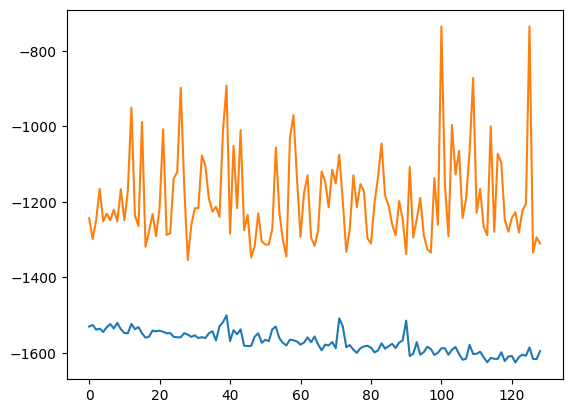

alpha 0.1 default_lr 0.0005


In [20]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [21]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [22]:
print(datetime.datetime.now())

2023-06-03 12:56:01.185744


Text(0, 0.5, 'loss')

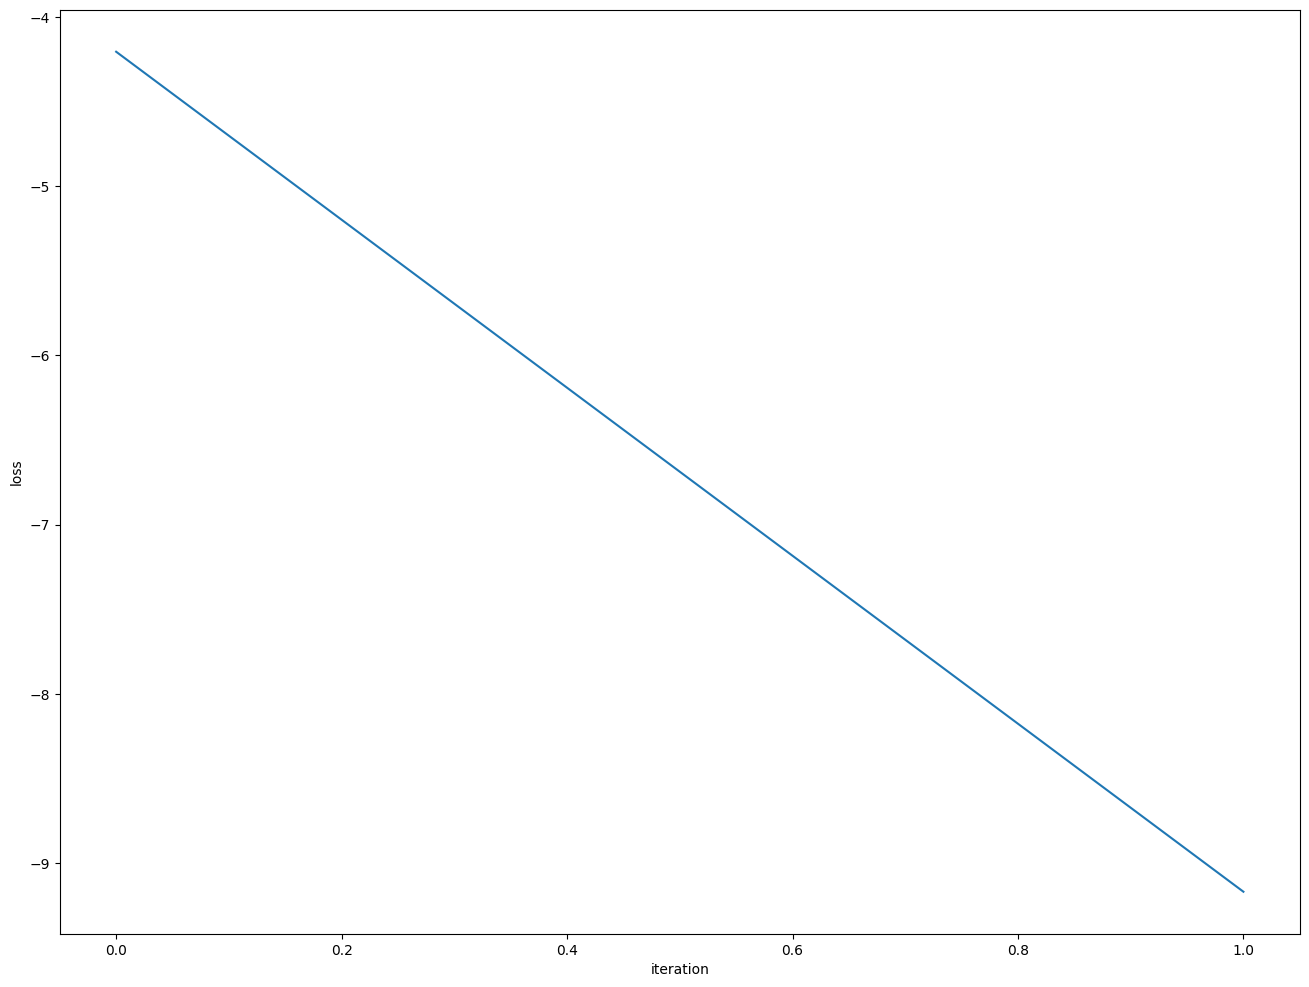

In [23]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


Text(0, 0.5, 'loss')

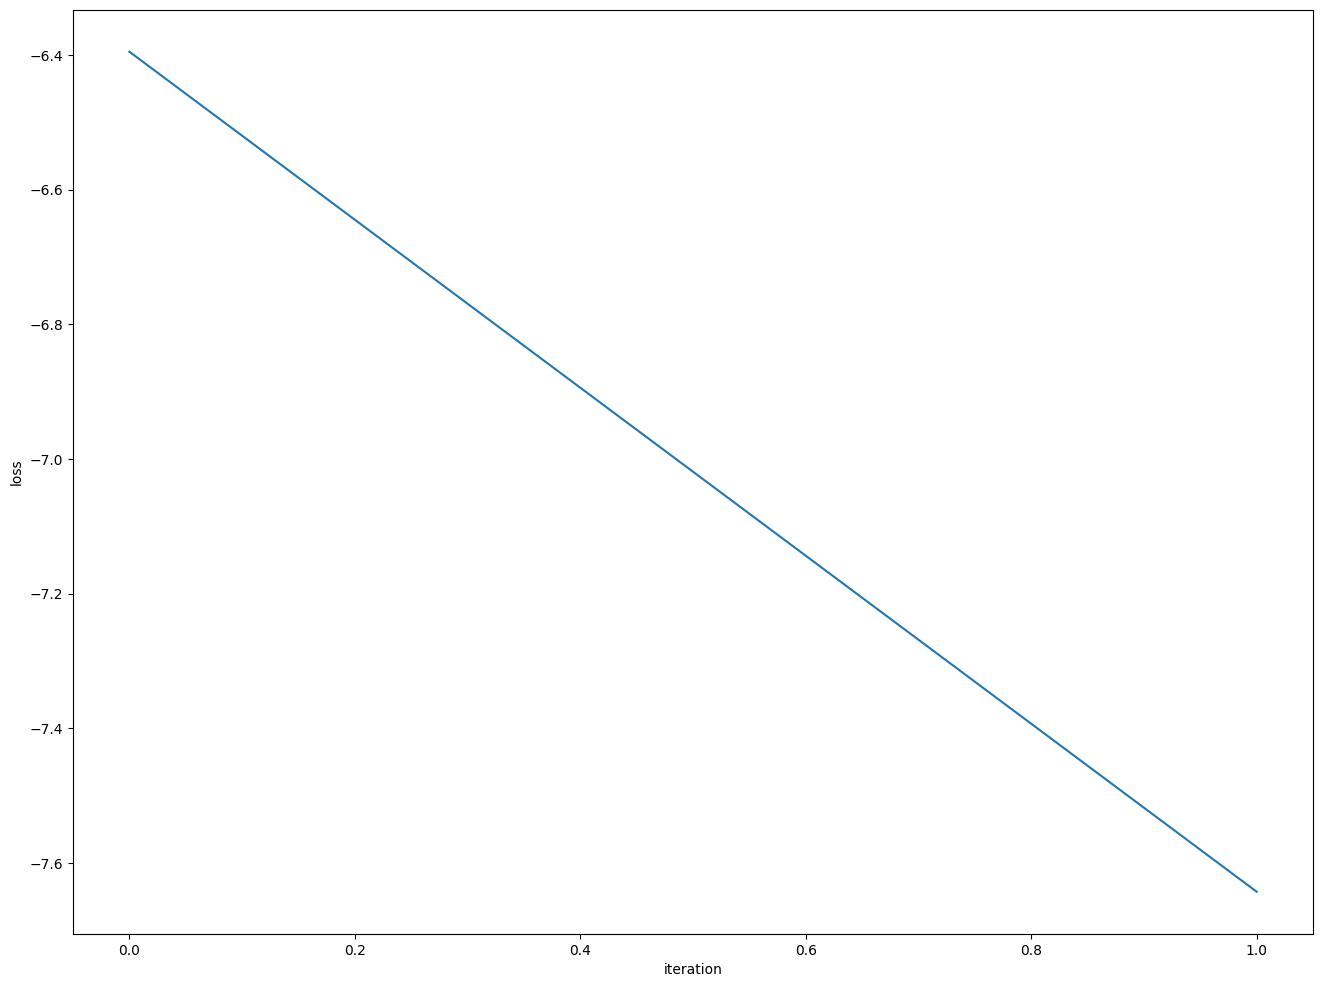

In [24]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


# Iter 3

In [25]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [26]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.74069  validloss 0.84737±0.00000  bestvalidloss 0.84737  last_update 0
train: iter 1  trainloss 0.73241  validloss 0.79577±0.00000  bestvalidloss 0.79577  last_update 0
train: iter 2  trainloss 0.72700  validloss 0.82181±0.00000  bestvalidloss 0.79577  last_update 1
train: iter 3  trainloss 0.72229  validloss 0.82663±0.00000  bestvalidloss 0.79577  last_update 2
train: iter 4  trainloss 0.71168  validloss 0.79233±0.00000  bestvalidloss 0.79233  last_update 0
train: iter 5  trainloss 0.71250  validloss 0.77720±0.00000  bestvalidloss 0.77720  last_update 0
train: iter 6  trainloss 0.71058  validloss 0.83602±0.00000  bestvalidloss 0.77720  last_update 1
train: iter 7  trainloss 0.70996  validloss 0.81447±0.00000  bestvalidloss 0.77720  last_update 2
train: iter 8  trainloss 0.70066  validloss 0.78594±0.00000  bestvalidloss 0.77720  last_update 3
train: iter 9  trainloss 0.70683  validloss 0.81967±0.00000  bestvalidloss 0.77720  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.66479  validloss 0.78709±0.00000  bestvalidloss 0.73489  last_update 7
train: iter 84  trainloss 0.66241  validloss 0.75011±0.00000  bestvalidloss 0.73489  last_update 8
train: iter 85  trainloss 0.65502  validloss 0.75935±0.00000  bestvalidloss 0.73489  last_update 9
train: iter 86  trainloss 0.65509  validloss 0.78186±0.00000  bestvalidloss 0.73489  last_update 10
train: iter 87  trainloss 0.65325  validloss 0.78195±0.00000  bestvalidloss 0.73489  last_update 11
train: iter 88  trainloss 0.65222  validloss 0.74639±0.00000  bestvalidloss 0.73489  last_update 12
train: iter 89  trainloss 0.65004  validloss 0.75010±0.00000  bestvalidloss 0.73489  last_update 13
train: iter 90  trainloss 0.66750  validloss 0.76359±0.00000  bestvalidloss 0.73489  last_update 14
train: iter 91  trainloss 0.66320  validloss 0.78852±0.00000  bestvalidloss 0.73489  last_update 15
train: iter 92  trainloss 0.66126  validloss 0.75631±0.00000  bestvalidloss 0.73489  last_update 16
tra

train: iter 165  trainloss 0.64064  validloss 0.75191±0.00000  bestvalidloss 0.73154  last_update 72
train: iter 166  trainloss 0.63830  validloss 0.76315±0.00000  bestvalidloss 0.73154  last_update 73
train: iter 167  trainloss 0.63522  validloss 0.75264±0.00000  bestvalidloss 0.73154  last_update 74
train: iter 168  trainloss 0.64353  validloss 0.75209±0.00000  bestvalidloss 0.73154  last_update 75
train: iter 169  trainloss 0.63819  validloss 0.75375±0.00000  bestvalidloss 0.73154  last_update 76
train: iter 170  trainloss 0.63959  validloss 0.75501±0.00000  bestvalidloss 0.73154  last_update 77
train: iter 171  trainloss 0.64126  validloss 0.75210±0.00000  bestvalidloss 0.73154  last_update 78
train: iter 172  trainloss 0.64043  validloss 0.75628±0.00000  bestvalidloss 0.73154  last_update 79
train: iter 173  trainloss 0.63983  validloss 0.76416±0.00000  bestvalidloss 0.73154  last_update 80
train: iter 174  trainloss 0.63295  validloss 0.75554±0.00000  bestvalidloss 0.73154  last_

([0.7406918592751026,
  0.7324065117165446,
  0.7269966997206211,
  0.7222854919731617,
  0.7116751538589596,
  0.7125033447518945,
  0.7105788955464959,
  0.7099609712138772,
  0.700664801709354,
  0.7068275533616543,
  0.7044689485803246,
  0.7011025099083781,
  0.6928940355777741,
  0.7039350738748908,
  0.6969711989164352,
  0.6909643854945898,
  0.6926169032230973,
  0.684569220803678,
  0.6865002604201436,
  0.6896778099238873,
  0.684975778311491,
  0.6890195969492197,
  0.6820815794169903,
  0.686136138252914,
  0.6865803239867091,
  0.6904306007549167,
  0.6806443896144628,
  0.6801049953326583,
  0.6797875612974167,
  0.6823571037501097,
  0.680850881524384,
  0.6771012637764215,
  0.6820264890789985,
  0.6724776037037372,
  0.674466123059392,
  0.6826342010870576,
  0.6723615661263466,
  0.6785821435973048,
  0.6751240514218807,
  0.6735662218183279,
  0.6718544146046043,
  0.676368347927928,
  0.6713953165337443,
  0.698911826685071,
  0.680105965025723,
  0.670524987019598

In [27]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -10.102305481511355
valid_loss:  -10.714008267879485
weight_alpha 1.0 h_min_tilde -12.323573 ell_tilde -10.22464603878498 kappa_tilde 0.0006902419101315424
train_loss:  -8.036958055877687
valid_loss:  -6.646249223136901
weight_alpha 0.1 h_min_tilde -12.323573 ell_tilde -7.7588162893295305 kappa_tilde 0.0004680488438115812


In [28]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1588.90151  validloss -1339.04589±0.00000  bestvalidloss -1339.04589  last_update 0
train: iter 1  trainloss -1609.52175  validloss -1123.34859±0.00000  bestvalidloss -1339.04589  last_update 1
train: iter 2  trainloss -1556.41815  validloss -1319.26178±0.00000  bestvalidloss -1339.04589  last_update 2
train: iter 3  trainloss -1594.17487  validloss -1142.96032±0.00000  bestvalidloss -1339.04589  last_update 3
train: iter 4  trainloss -1573.17845  validloss -1347.74070±0.00000  bestvalidloss -1347.74070  last_update 0
train: iter 5  trainloss -1612.92511  validloss -1362.06128±0.00000  bestvalidloss -1362.06128  last_update 0
train: iter 6  trainloss -1584.81547  validloss -1301.17800±0.00000  bestvalidloss -1362.06128  last_update 1
train: iter 7  trainloss -1613.62537  validloss -1382.68500±0.00000  bestvalidloss -1382.68500  last_update 0
train: iter 8  trainloss -1608.89209  validloss -1321.52065±0.00000  bestva

train: iter 74  trainloss -1629.41004  validloss -1049.33346±0.00000  bestvalidloss -1382.68500  last_update 67
train: iter 75  trainloss -1629.94246  validloss -1155.71906±0.00000  bestvalidloss -1382.68500  last_update 68
train: iter 76  trainloss -1618.42943  validloss -1013.23600±0.00000  bestvalidloss -1382.68500  last_update 69
train: iter 77  trainloss -1614.02700  validloss -1197.50068±0.00000  bestvalidloss -1382.68500  last_update 70
train: iter 78  trainloss -1619.18524  validloss -729.58731±0.00000  bestvalidloss -1382.68500  last_update 71
train: iter 79  trainloss -1626.54606  validloss -1222.37810±0.00000  bestvalidloss -1382.68500  last_update 72
train: iter 80  trainloss -1609.47866  validloss -1233.50657±0.00000  bestvalidloss -1382.68500  last_update 73
train: iter 81  trainloss -1628.21584  validloss -1285.57463±0.00000  bestvalidloss -1382.68500  last_update 74
train: iter 82  trainloss -1636.24794  validloss -1169.32190±0.00000  bestvalidloss -1382.68500  last_upd

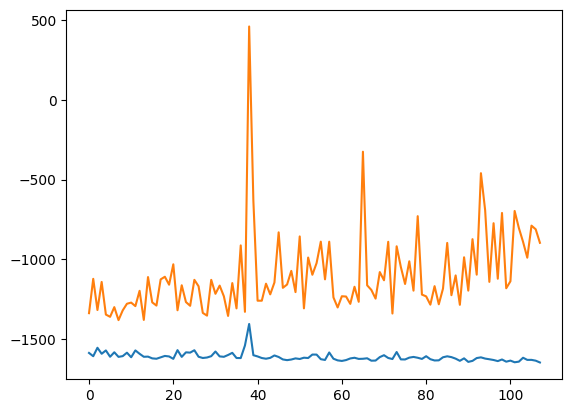

alpha 0.1 default_lr 0.0005


In [29]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [30]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [31]:
print(datetime.datetime.now())

2023-06-03 13:15:53.791835


# 評価関数計算

In [32]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [33]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.75863  validloss 0.90183±0.00000  bestvalidloss 0.90183  last_update 0
train: iter 1  trainloss 0.73421  validloss 0.82385±0.00000  bestvalidloss 0.82385  last_update 0
train: iter 2  trainloss 0.73390  validloss 0.82376±0.00000  bestvalidloss 0.82376  last_update 0
train: iter 3  trainloss 0.72275  validloss 0.81643±0.00000  bestvalidloss 0.81643  last_update 0
train: iter 4  trainloss 0.71473  validloss 0.81122±0.00000  bestvalidloss 0.81122  last_update 0
train: iter 5  trainloss 0.71505  validloss 0.82691±0.00000  bestvalidloss 0.81122  last_update 1
train: iter 6  trainloss 0.72094  validloss 0.80236±0.00000  bestvalidloss 0.80236  last_update 0
train: iter 7  trainloss 0.71192  validloss 0.81607±0.00000  bestvalidloss 0.80236  last_update 1
train: iter 8  trainloss 0.71840  validloss 0.81560±0.00000  bestvalidloss 0.80236  last_update 2
train: iter 9  trainloss 0.71464  validloss 0.79668±0.00000  bestvalidloss 0.79668  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.68248  validloss 0.83942±0.00000  bestvalidloss 0.77350  last_update 14
train: iter 84  trainloss 0.68063  validloss 0.80360±0.00000  bestvalidloss 0.77350  last_update 15
train: iter 85  trainloss 0.67465  validloss 0.80230±0.00000  bestvalidloss 0.77350  last_update 16
train: iter 86  trainloss 0.68198  validloss 0.78715±0.00000  bestvalidloss 0.77350  last_update 17
train: iter 87  trainloss 0.68014  validloss 0.80503±0.00000  bestvalidloss 0.77350  last_update 18
train: iter 88  trainloss 0.67944  validloss 0.79647±0.00000  bestvalidloss 0.77350  last_update 19
train: iter 89  trainloss 0.67699  validloss 0.79070±0.00000  bestvalidloss 0.77350  last_update 20
train: iter 90  trainloss 0.67817  validloss 0.78893±0.00000  bestvalidloss 0.77350  last_update 21
train: iter 91  trainloss 0.67974  validloss 0.83499±0.00000  bestvalidloss 0.77350  last_update 22
train: iter 92  trainloss 0.67719  validloss 0.82434±0.00000  bestvalidloss 0.77350  last_update 23


train: iter 165  trainloss 0.65940  validloss 0.77852±0.00000  bestvalidloss 0.76521  last_update 4
train: iter 166  trainloss 0.66543  validloss 0.79246±0.00000  bestvalidloss 0.76521  last_update 5
train: iter 167  trainloss 0.66261  validloss 0.78378±0.00000  bestvalidloss 0.76521  last_update 6
train: iter 168  trainloss 0.67119  validloss 0.79082±0.00000  bestvalidloss 0.76521  last_update 7
train: iter 169  trainloss 0.65801  validloss 0.78437±0.00000  bestvalidloss 0.76521  last_update 8
train: iter 170  trainloss 0.66314  validloss 0.79712±0.00000  bestvalidloss 0.76521  last_update 9
train: iter 171  trainloss 0.65796  validloss 0.81169±0.00000  bestvalidloss 0.76521  last_update 10
train: iter 172  trainloss 0.66437  validloss 0.78456±0.00000  bestvalidloss 0.76521  last_update 11
train: iter 173  trainloss 0.65844  validloss 0.78367±0.00000  bestvalidloss 0.76521  last_update 12
train: iter 174  trainloss 0.66295  validloss 0.80524±0.00000  bestvalidloss 0.76521  last_update

train: iter 247  trainloss 0.64739  validloss 0.80250±0.00000  bestvalidloss 0.76521  last_update 86
train: iter 248  trainloss 0.65643  validloss 0.81407±0.00000  bestvalidloss 0.76521  last_update 87
train: iter 249  trainloss 0.64980  validloss 0.81127±0.00000  bestvalidloss 0.76521  last_update 88
train: iter 250  trainloss 0.65076  validloss 0.79174±0.00000  bestvalidloss 0.76521  last_update 89
train: iter 251  trainloss 0.64928  validloss 0.81059±0.00000  bestvalidloss 0.76521  last_update 90
train: iter 252  trainloss 0.64782  validloss 0.79492±0.00000  bestvalidloss 0.76521  last_update 91
train: iter 253  trainloss 0.65269  validloss 0.80136±0.00000  bestvalidloss 0.76521  last_update 92
train: iter 254  trainloss 0.64833  validloss 0.79526±0.00000  bestvalidloss 0.76521  last_update 93
train: iter 255  trainloss 0.64644  validloss 0.77852±0.00000  bestvalidloss 0.76521  last_update 94
train: iter 256  trainloss 0.64839  validloss 0.80686±0.00000  bestvalidloss 0.76521  last_

([0.7586271151900291,
  0.7342126697301865,
  0.7338983858004212,
  0.7227521371096373,
  0.7147334560751915,
  0.7150456028059125,
  0.7209379849024117,
  0.7119226075708867,
  0.718401794321835,
  0.7146448629908264,
  0.7143180957064033,
  0.7134449811652303,
  0.7042065810412168,
  0.7046557047404349,
  0.7035458004102111,
  0.7066473938524723,
  0.7016230292618275,
  0.7012430459260941,
  0.6992388103157282,
  0.7035838440060616,
  0.7034844755195081,
  0.701798162329942,
  0.6971166722476483,
  0.7032046033069491,
  0.6979421108961106,
  0.695425677113235,
  0.6981451526284218,
  0.6957328896969557,
  0.7152683118358254,
  0.6955573219805956,
  0.6969442812725901,
  0.696410774346441,
  0.6948639053851366,
  0.695434057340026,
  0.6944782562553883,
  0.6923001233488322,
  0.6865831629373134,
  0.6933785259723664,
  0.6933334922417999,
  0.6873982738703489,
  0.6923132035881281,
  0.6923637539148331,
  0.6922056159004569,
  0.6918675361201168,
  0.6917912526987493,
  0.68687890274

In [34]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -8.120170993328093
valid_loss:  -1.0055975627899172
weight_alpha 1.0 h_min_tilde -12.32247 ell_tilde -6.697256307220458 kappa_tilde 0.00042162902344451
train_loss:  -7.870378547668456
valid_loss:  -5.219832325744629
weight_alpha 0.1 h_min_tilde -12.32247 ell_tilde -7.340269303283691 kappa_tilde 0.00044801174910733677


In [35]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 29.78320  validloss 31.16612±0.00000  bestvalidloss 31.16612  last_update 0
train: iter 1  trainloss 25.15716  validloss 26.57285±0.00000  bestvalidloss 26.57285  last_update 0
train: iter 2  trainloss 21.58444  validloss 22.64508±0.00000  bestvalidloss 22.64508  last_update 0
train: iter 3  trainloss 18.60713  validloss 19.44514±0.00000  bestvalidloss 19.44514  last_update 0
train: iter 4  trainloss 15.98602  validloss 16.77042±0.00000  bestvalidloss 16.77042  last_update 0
train: iter 5  trainloss 13.97718  validloss 14.44931±0.00000  bestvalidloss 14.44931  last_update 0
train: iter 6  trainloss 12.16864  validloss 12.50538±0.00000  bestvalidloss 12.50538  last_update 0
train: iter 7  trainloss 10.71455  validloss 11.08241±0.00000  bestvalidloss 11.08241  last_update 0
train: iter 8  trainloss 9.47108  validloss 9.63722±0.00000  bestvalidloss 9.63722  last_update 0
train: iter 9  trainloss 8.39126  validloss 8.52985±0.00000  bestvalidloss 8.52985  last_updat

train: iter 90  trainloss -0.62864  validloss -0.70418±0.00000  bestvalidloss -0.70418  last_update 0
train: iter 91  trainloss -0.62789  validloss -0.69134±0.00000  bestvalidloss -0.70418  last_update 1
train: iter 92  trainloss -0.63753  validloss -0.71762±0.00000  bestvalidloss -0.71762  last_update 0
train: iter 93  trainloss -0.67381  validloss -0.73118±0.00000  bestvalidloss -0.73118  last_update 0
train: iter 94  trainloss -0.64480  validloss -0.74998±0.00000  bestvalidloss -0.74998  last_update 0
train: iter 95  trainloss -0.66178  validloss -0.73015±0.00000  bestvalidloss -0.74998  last_update 1
train: iter 96  trainloss -0.68364  validloss -0.79726±0.00000  bestvalidloss -0.79726  last_update 0
train: iter 97  trainloss -0.67785  validloss -0.80068±0.00000  bestvalidloss -0.80068  last_update 0
train: iter 98  trainloss -0.70498  validloss -0.76369±0.00000  bestvalidloss -0.80068  last_update 1
train: iter 99  trainloss -0.68714  validloss -0.78647±0.00000  bestvalidloss -0.8

train: iter 185  trainloss -0.83423  validloss -1.02319±0.00000  bestvalidloss -1.11050  last_update 11
train: iter 186  trainloss -0.83671  validloss -1.05412±0.00000  bestvalidloss -1.11050  last_update 12
train: iter 187  trainloss -0.80749  validloss -1.07381±0.00000  bestvalidloss -1.11050  last_update 13
train: iter 188  trainloss -0.82120  validloss -1.11042±0.00000  bestvalidloss -1.11050  last_update 14
train: iter 189  trainloss -0.84108  validloss -1.00390±0.00000  bestvalidloss -1.11050  last_update 15
train: iter 190  trainloss -0.79858  validloss -1.06295±0.00000  bestvalidloss -1.11050  last_update 16
train: iter 191  trainloss -0.79901  validloss -1.02231±0.00000  bestvalidloss -1.11050  last_update 17
train: iter 192  trainloss -0.84307  validloss -1.02789±0.00000  bestvalidloss -1.11050  last_update 18
train: iter 193  trainloss -0.83569  validloss -1.03302±0.00000  bestvalidloss -1.11050  last_update 19
train: iter 194  trainloss -0.78821  validloss -1.06992±0.00000 

train: iter 264  trainloss -0.79991  validloss -1.06338±0.00000  bestvalidloss -1.14627  last_update 49
train: iter 265  trainloss -0.82064  validloss -1.04418±0.00000  bestvalidloss -1.14627  last_update 50
train: iter 266  trainloss -0.81492  validloss -1.06207±0.00000  bestvalidloss -1.14627  last_update 51
train: iter 267  trainloss -0.80966  validloss -1.06602±0.00000  bestvalidloss -1.14627  last_update 52
train: iter 268  trainloss -0.80890  validloss -1.07062±0.00000  bestvalidloss -1.14627  last_update 53
train: iter 269  trainloss -0.80707  validloss -1.04746±0.00000  bestvalidloss -1.14627  last_update 54
train: iter 270  trainloss -0.82556  validloss -1.08122±0.00000  bestvalidloss -1.14627  last_update 55
train: iter 271  trainloss -0.77467  validloss -1.11470±0.00000  bestvalidloss -1.14627  last_update 56
train: iter 272  trainloss -0.78391  validloss -1.06039±0.00000  bestvalidloss -1.14627  last_update 57
train: iter 273  trainloss -0.79359  validloss -1.11198±0.00000 

In [36]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-1.2325, -1.7160, -3.3080, -3.9965], requires_grad=True)


In [37]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 1.87137  validloss 231.43810±0.00000  bestvalidloss 231.43810  last_update 0
train: iter 1  trainloss 1.76537  validloss 236.54835±0.00000  bestvalidloss 231.43810  last_update 1
train: iter 2  trainloss 1.73162  validloss 257.41433±0.00000  bestvalidloss 231.43810  last_update 2
train: iter 3  trainloss 1.75367  validloss 262.35838±0.00000  bestvalidloss 231.43810  last_update 3
train: iter 4  trainloss 1.71635  validloss 229.05341±0.00000  bestvalidloss 229.05341  last_update 0
train: iter 5  trainloss 1.71922  validloss 261.37974±0.00000  bestvalidloss 229.05341  last_update 1
train: iter 6  trainloss 1.71048  validloss 231.07033±0.00000  bestvalidloss 229.05341  last_update 2
train: iter 7  trainloss 1.71754  validloss 213.84340±0.00000  bestvalidloss 213.84340  last_update 0
train: iter 8  trainloss 1.68294  validloss 253.47384±0.00000  bestvalidloss 213.84340  last_update 1
train: iter 9  trainloss 1.71626  validloss 252.72160±0.00000  bestvalidloss 213.8

train: iter 81  trainloss 1.65100  validloss 219.06480±0.00000  bestvalidloss 213.84340  last_update 74
train: iter 82  trainloss 1.65207  validloss 239.92763±0.00000  bestvalidloss 213.84340  last_update 75
train: iter 83  trainloss 1.62922  validloss 239.31243±0.00000  bestvalidloss 213.84340  last_update 76
train: iter 84  trainloss 1.66684  validloss 243.43334±0.00000  bestvalidloss 213.84340  last_update 77
train: iter 85  trainloss 1.65579  validloss 229.11305±0.00000  bestvalidloss 213.84340  last_update 78
train: iter 86  trainloss 1.62610  validloss 258.08447±0.00000  bestvalidloss 213.84340  last_update 79
train: iter 87  trainloss 1.65013  validloss 247.91123±0.00000  bestvalidloss 213.84340  last_update 80
train: iter 88  trainloss 1.66651  validloss 245.19020±0.00000  bestvalidloss 213.84340  last_update 81
train: iter 89  trainloss 1.68171  validloss 253.43536±0.00000  bestvalidloss 213.84340  last_update 82
train: iter 90  trainloss 1.63349  validloss 230.82241±0.00000  

train: iter 161  trainloss 1.65290  validloss 240.54833±0.00000  bestvalidloss 203.39692  last_update 60
train: iter 162  trainloss 1.60428  validloss 266.52242±0.00000  bestvalidloss 203.39692  last_update 61
train: iter 163  trainloss 1.63380  validloss 263.72283±0.00000  bestvalidloss 203.39692  last_update 62
train: iter 164  trainloss 1.63410  validloss 250.36719±0.00000  bestvalidloss 203.39692  last_update 63
train: iter 165  trainloss 1.62125  validloss 235.76737±0.00000  bestvalidloss 203.39692  last_update 64
train: iter 166  trainloss 1.60504  validloss 261.08349±0.00000  bestvalidloss 203.39692  last_update 65
train: iter 167  trainloss 1.59912  validloss 245.82617±0.00000  bestvalidloss 203.39692  last_update 66
train: iter 168  trainloss 1.62394  validloss 246.45638±0.00000  bestvalidloss 203.39692  last_update 67
train: iter 169  trainloss 1.63392  validloss 252.09058±0.00000  bestvalidloss 203.39692  last_update 68
train: iter 170  trainloss 1.62749  validloss 299.51796

In [38]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-10.2530)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(6.2975)


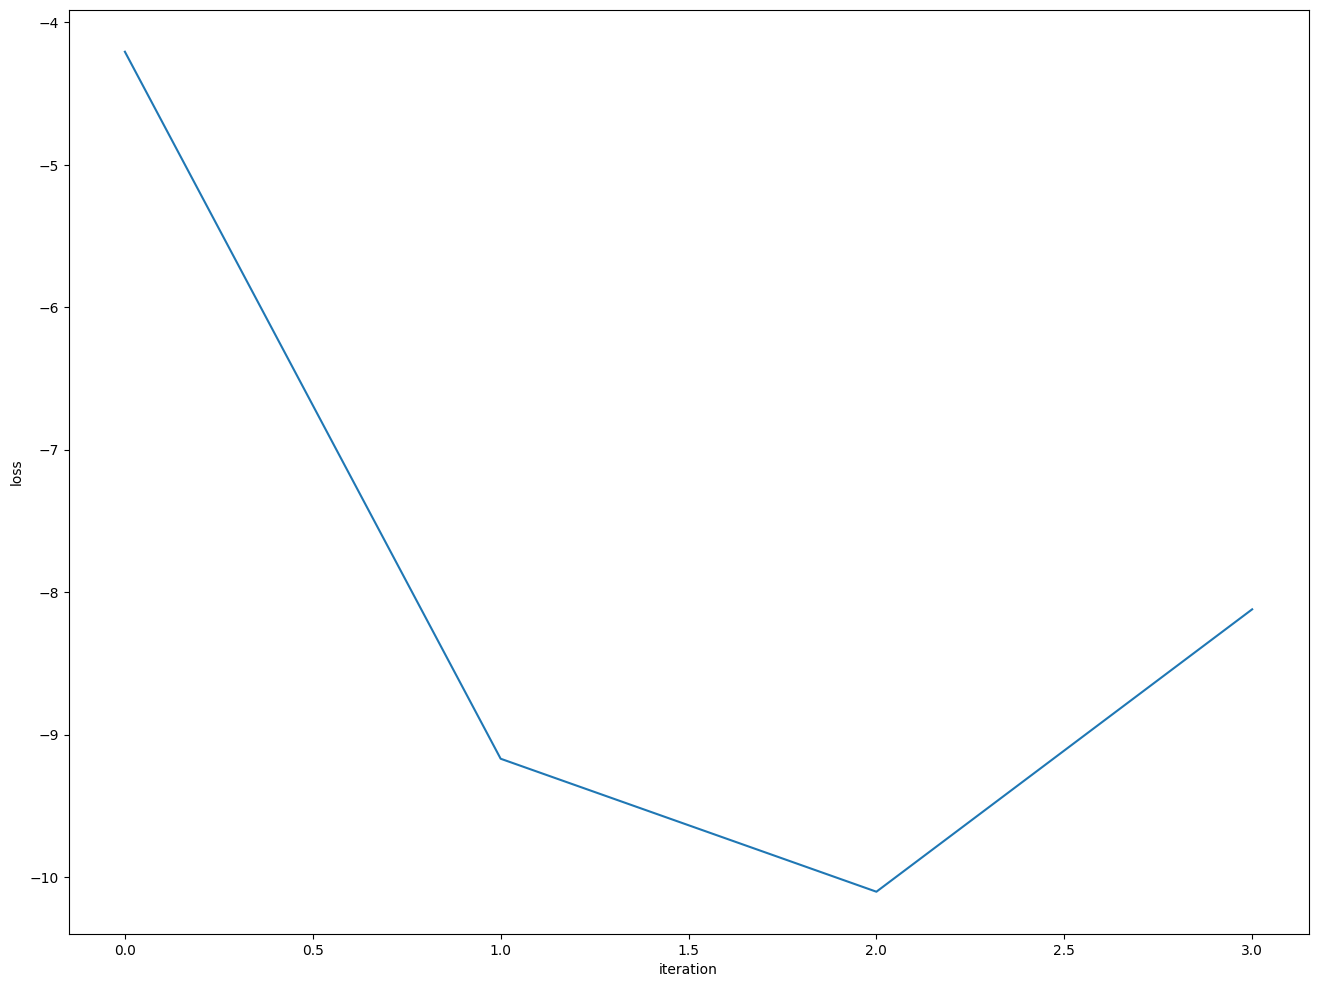

In [39]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

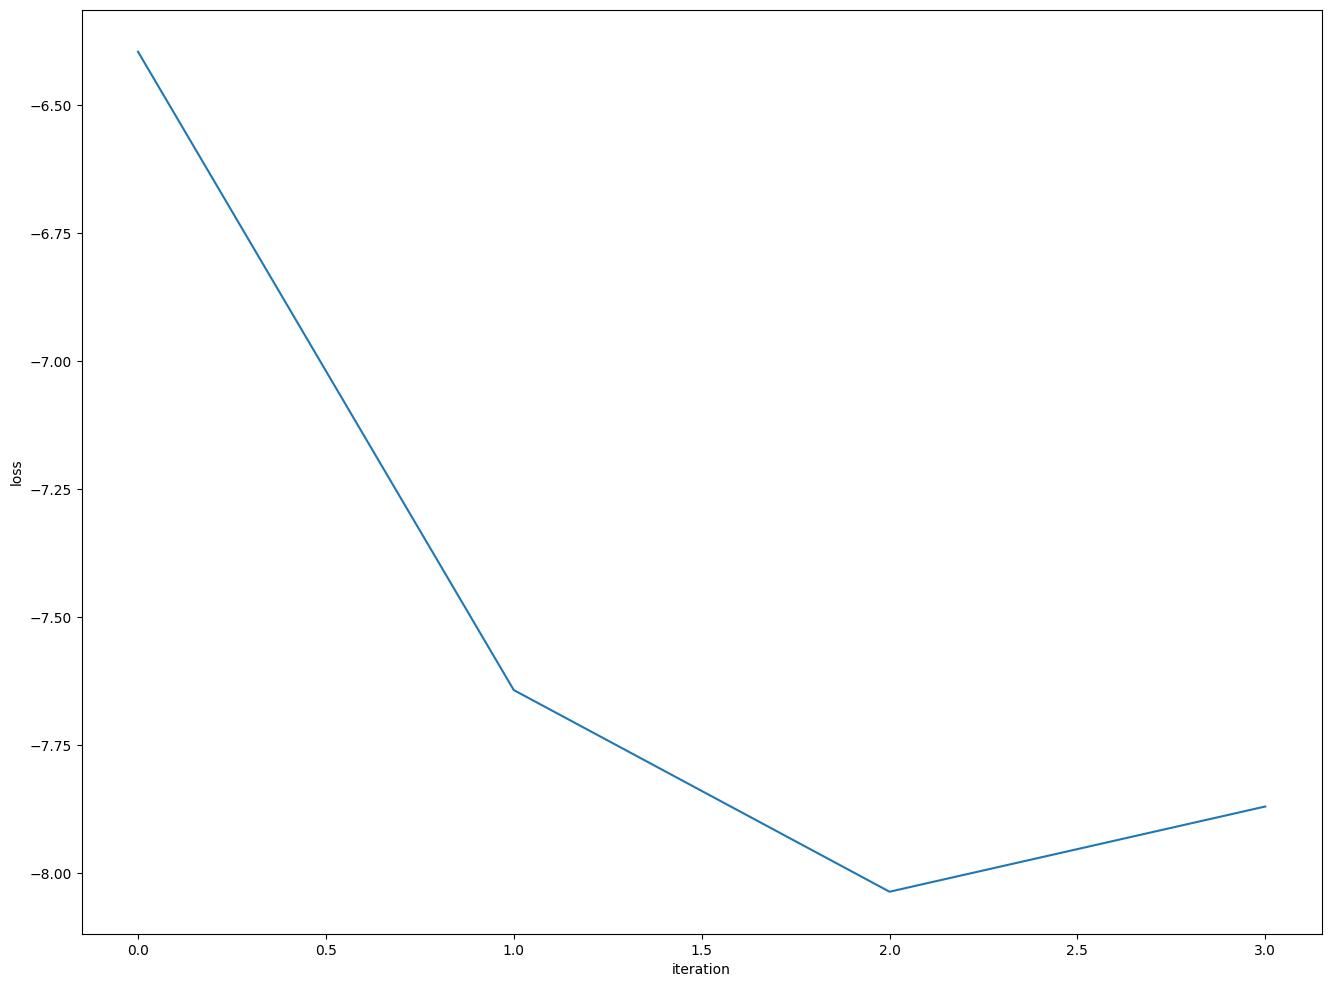

In [40]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")